In [1]:
%load_ext autoreload
%autoreload 2

# Space Charge Benchmark

Reproduce plots in:

C. E. Mayes, R. D. Ryne, D. C. Sagan, *3D Space Charge in Bmad*, IPAC2018, Vancouver, BC, Canada
https://accelconf.web.cern.ch/ipac2018/papers/thpak085.pdf


In [2]:
from spacecharge.freespace import igf_mesh3, spacecharge_mesh
from spacecharge.deposit import deposit_particles
from spacecharge.testing import test_particles

In [3]:
import numpy as np

from scipy.signal import fftconvolve, oaconvolve
from scipy.interpolate import interpn

import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = (8,6)
%config InlineBackend.figure_format = 'retina'

# Create Gaussian particles

In [4]:
RATIO = 1

NP = 10000000
# Beam sizes in m
SIGX = 0.001
SIGY = 0.001
SIGZ = 0.001 * RATIO 
CHARGE = 1e-9 # C

BINS = (128,128,128)

particles, weights = test_particles(n_particle=NP, sigma_x=SIGX, sigma_y=SIGY, sigma_z=SIGZ,
                                total_charge=CHARGE)

particles.shape

(10000000, 3)

In [5]:
particles[:,2].min()/SIGZ, particles[:,2].max()/SIGZ

(-5.074274469437327, 5.531436981855725)

In [6]:
rho_mesh, deltas, coord_vecs = deposit_particles(particles, weights=weights, bins=BINS)
rho_mesh.shape, deltas, coord_vecs.shape

((128, 128, 128),
 array([8.17554174e-05, 8.19585614e-05, 8.28571207e-05]),
 (3, 128))

In [7]:
# Coordinate meshes
X, Y, Z = np.meshgrid(*coord_vecs, indexing='ij') 

# Space Charge mesh

In [8]:
%%time
Ex_mesh = spacecharge_mesh(rho_mesh, deltas, gamma=1, component='x')

CPU times: user 4.57 s, sys: 1.71 s, total: 6.28 s
Wall time: 6.35 s


In [9]:
%%time
Ey_mesh = spacecharge_mesh(rho_mesh, deltas, gamma=1, component='y')

CPU times: user 4.41 s, sys: 1.46 s, total: 5.87 s
Wall time: 5.93 s


In [10]:
%%time
Ez_mesh = spacecharge_mesh(rho_mesh, deltas, gamma=1, component='z')

CPU times: user 4.22 s, sys: 1.3 s, total: 5.52 s
Wall time: 5.58 s


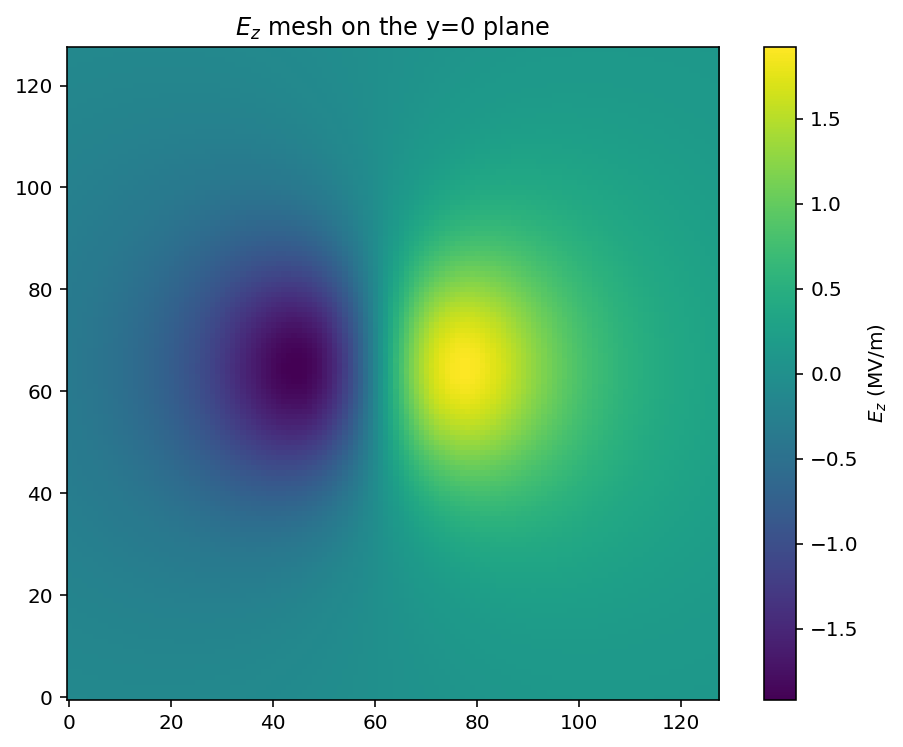

In [11]:
plt.imshow(Ez_mesh[:,BINS[1]//2,:]/1e6, origin='lower')
plt.title(r'$E_z$' +' mesh on the y=0 plane')
plt.colorbar(label=r'$E_z$'+' (MV/m)')

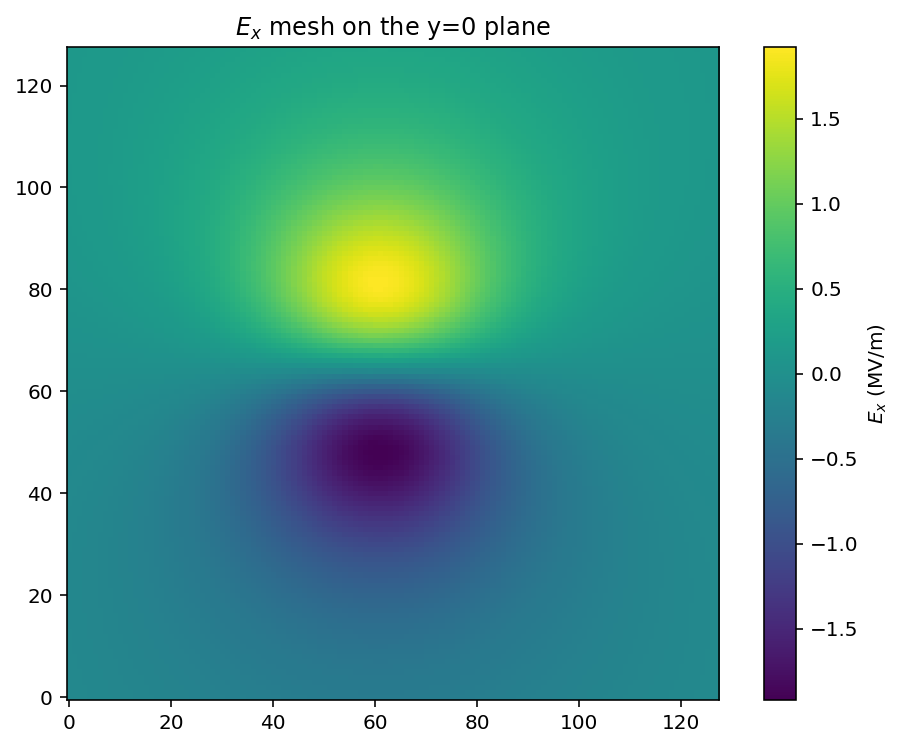

In [12]:
plt.imshow(Ex_mesh[:,BINS[1]//2,:]/1e6, origin='lower')
plt.title(r'$E_x$' +' mesh on the y=0 plane')
plt.colorbar(label=r'$E_x$'+' (MV/m)')

64


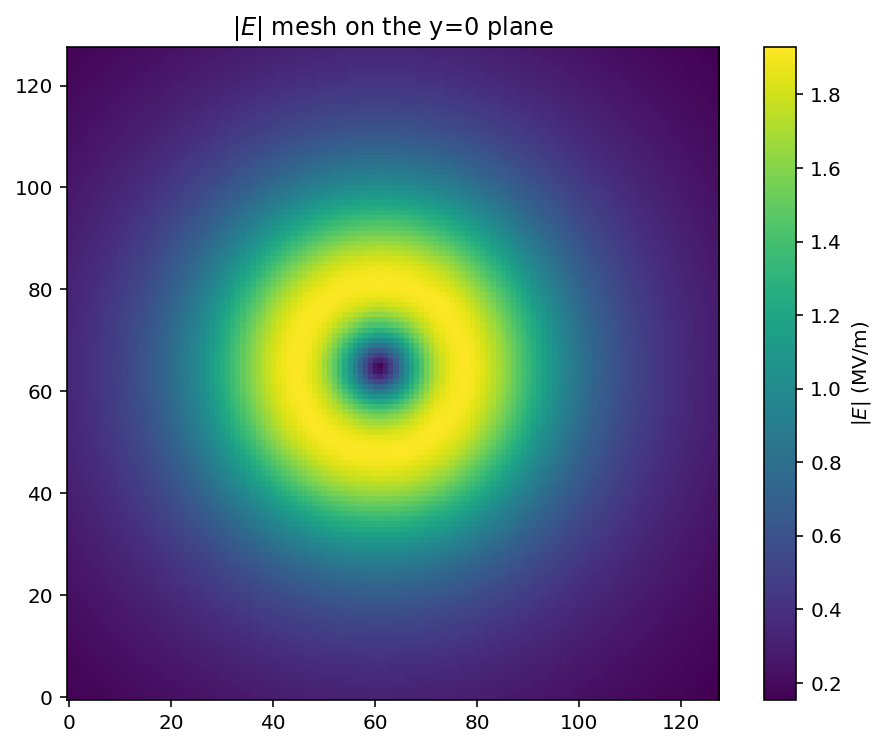

In [13]:
iy =  BINS[1]//2 
print(iy)

Emag = np.sqrt((Ex_mesh[:,iy,:]**2 + Ey_mesh[:,iy,:]**2 + Ez_mesh[:,iy,:]**2))

plt.imshow(Emag/1e6, origin='lower')
plt.title(r'$|E|$' +' mesh on the y=0 plane')
plt.colorbar(label=r'$|E|$'+' (MV/m)')

Text(0, 0.5, '$E_z~(MV/m)$')

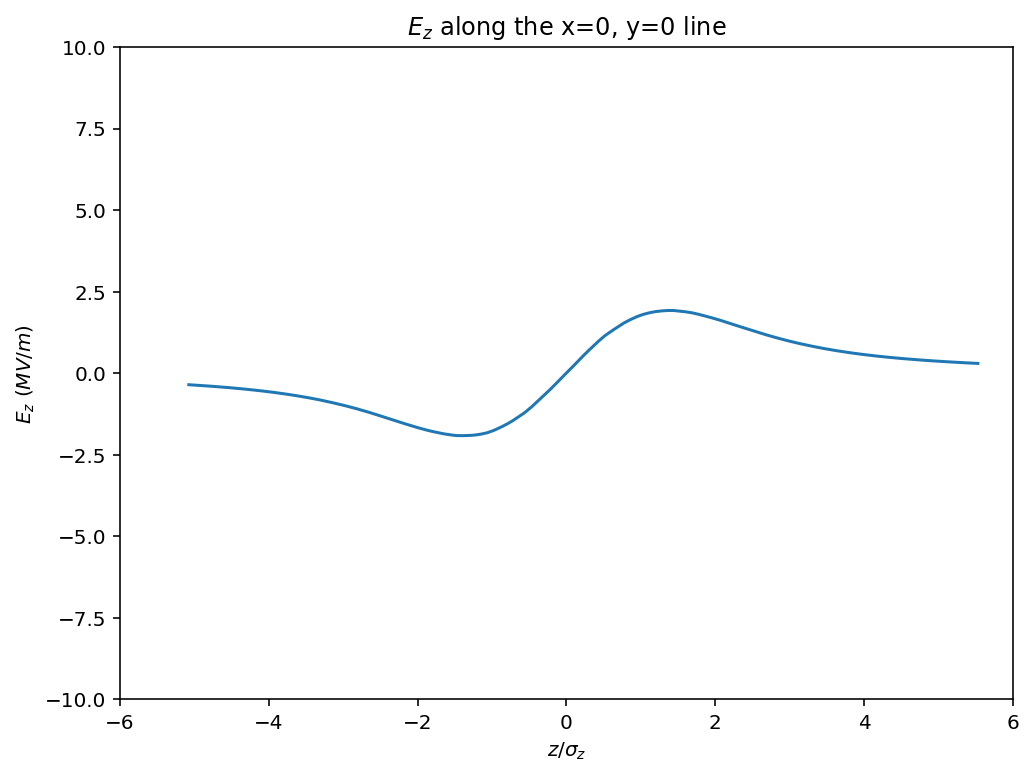

In [14]:
z0 = np.linspace(coord_vecs[2].min(), coord_vecs[2].max() , 1000)
zpts = np.array([[0,0,z] for z in z0])

# Plot on x=0, y=0 line
Ez0 = interpn(coord_vecs, Ez_mesh, zpts)

fig, ax = plt.subplots()
ax.plot(z0/SIGZ, Ez0/1e6)

ax.set_title(r'$E_z$'+' along the x=0, y=0 line')
ax.set_xlim(-6, 6)
ax.set_ylim(-10,10)
ax.set_xlabel(r'$z/\sigma_z$')
ax.set_ylabel(r'$E_z~(MV/m)$')



# Summary plots

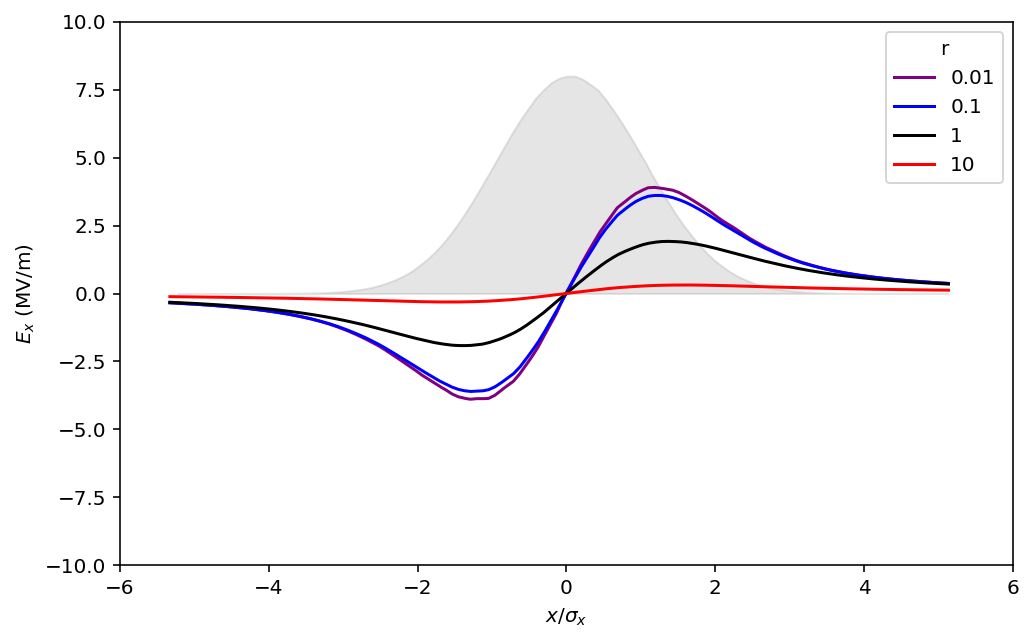

In [15]:
# Ex 
x0 = np.linspace(coord_vecs[0].min(), coord_vecs[0].max() , 1000)
xpts = np.array([[x,0,0] for x in x0])

fig, ax = plt.subplots(figsize=(8,5))

COLOR = {1:'black', 0.1:'blue', 0.01: 'purple', 10:'red'}

for ratio in [.01, .1, 1, 10]:
    deltas0 = deltas.copy()
    deltas0[2] *= ratio
    Ex_mesh = spacecharge_mesh(rho_mesh, deltas0, gamma=1, component='x')

    Ex0 = interpn(coord_vecs, Ex_mesh, xpts)
    
    ax.plot(x0/SIGX, Ex0/1e6, color=COLOR[ratio], label=f'{ratio}')
    
    
# Charge density    
#ax2 = ax.twinx()      
H, edges = np.histogram(particles[:, 0], bins=100)
ax.fill_between(edges[1:]/SIGX, 0, H/H.max()*8, color='gray', alpha=0.2)    

ax.set_xlim(-6, 6)
ax.set_ylim(-10,10)    
ax.set_xlabel(r'$x/\sigma_x$')
ax.set_ylabel(r'$E_x$'+' (MV/m)')    
ax.legend(title='r')

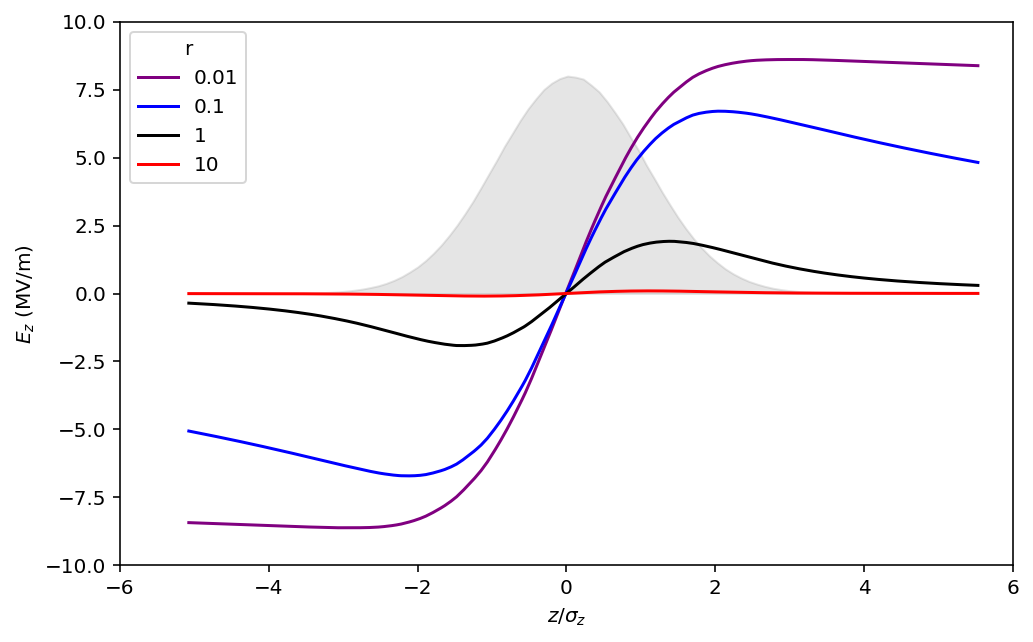

In [16]:
# Ez 
z0 = np.linspace(coord_vecs[2].min(), coord_vecs[2].max() , 1000)
zpts = np.array([[0,0,z] for z in z0])

fig, ax = plt.subplots(figsize=(8,5))

COLOR = {1:'black', 0.1:'blue', 0.01: 'purple', 10:'red'}

for ratio in [.01, .1, 1, 10]:
    deltas0 = deltas.copy()
    deltas0[2] *= ratio
    Ez_mesh = spacecharge_mesh(rho_mesh, deltas0, gamma=1, component='z')

    Ez0 = interpn(coord_vecs, Ez_mesh, zpts)
    
    ax.plot(z0/SIGZ, Ez0/1e6, color=COLOR[ratio], label=f'{ratio}')
    
    
# Charge density    
#ax2 = ax.twinx()      
H, edges = np.histogram(particles[:, 2], bins=100)
ax.fill_between(edges[1:]/SIGZ, 0, H/H.max()*8, color='gray', alpha=0.2)    

ax.set_xlim(-6, 6)
ax.set_ylim(-10,10)    
ax.set_xlabel(r'$z/\sigma_z$')
ax.set_ylabel(r'$E_z$'+' (MV/m)')     
ax.legend(title='r')